In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.0 MB ? eta -:--:--
   -- ------------------------------------- 1.6/24.0 MB 6.0 MB/s eta 0:00:04
   ----- ---------------------------------- 3.1/24.0 MB 6.4 MB/s eta 0:00:04
   ------- -------------------------------- 4.5/24.0 MB 6.4 MB/s eta 0:00:04
   ---------- ----------------------------- 6.0/24.0 MB 6.6 MB/s eta 0:00:03
   ------------ --------------------------- 7.3/24.0 MB 6.6 MB/s eta 0:00:03
   -------------- ------------------------- 8.7/24.0 MB 6.7 MB/s eta 0:00:03
   ----------------- ---------------------- 10.2/24.0 MB 6.6 MB/s eta 0:00:03
   ------------------- -------------------- 11.5/24.0 MB 6.6 MB/s eta 0:00:02
   --------------------- ------------------ 12.8/24.0 MB 6.4 MB/s eta 0:00:02
   ----------------------- ---------------- 14.2/24.0 MB 6.4 MB/s eta 0:00:02
   -------------------------- ------------- 15.7/24.0 MB 6.5 MB/s eta 0:00:02
   -----

  You can safely remove it manually.
  You can safely remove it manually.


In [4]:
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [5]:
data = pd.read_csv(r'C:\Python_Labs\AI Bootcamp 2025\fake_news_data.csv')

In [6]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


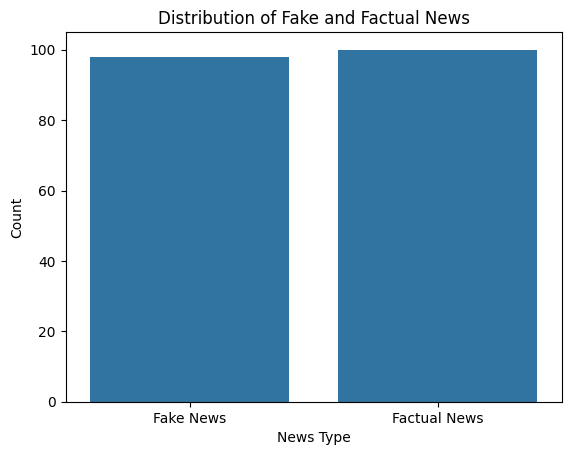

In [7]:
sns.countplot(x='fake_or_factual', data=data)
plt.title('Distribution of Fake and Factual News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

In [8]:
nlp = spacy.load('en_core_web_sm')

In [16]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(fact_news['text'])) 

`nlp.pipe` is a method in spaCy used to process multiple texts efficiently in a pipeline. 

- It batches the texts for faster processing.  
- It avoids the overhead of processing each text individually, making it ideal for large datasets.


In [17]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

The `doc: spacy.tokens.doc.Doc` parameter uses **type hints** in Python to specify the expected type of the `doc` parameter.  

- **Colon (`:`):** Separates the parameter name (`doc`) from its type annotation (`spacy.tokens.doc.Doc`).  
- **Type Annotation:** Indicates that the function expects `doc` to be a `Doc` object from spaCy's library, representing a processed text containing tokens, POS tags, entities, etc.  

This helps improve code readability and allows tools like linters or IDEs to check for type correctness.


In [18]:

fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

if fake_spaceydocs:
    for ix, doc in enumerate(fake_spaceydocs):
        tags = extract_token_tags(doc)
        tags = pd.DataFrame(tags)
        tags.columns = columns
        fake_tagsdf.append(tags)
            
    fake_tagsdf = pd.concat(fake_tagsdf)   
else:
    print("No fake news documents to process.")

fact_tagsdf = []

if fact_spaceydocs:
    for ix, doc in enumerate(fact_spaceydocs):
        tags = extract_token_tags(doc)
        tags = pd.DataFrame(tags)
        tags.columns = columns
        fact_tagsdf.append(tags)
            
    fact_tagsdf = pd.concat(fact_tagsdf)
else:
    print("No factual news documents to process.")

In [20]:
fake_tagsdf.head()


,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [21]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head()

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875


The `.size()` function in this code is used to count the number of occurrences for each group created by `groupby(['token', 'pos_tag'])`, effectively providing the frequency of each (token, pos_tag) pair. Without using `groupby`, `.size()` would simply return the total number of rows in the DataFrame, not the counts for each specific group.

In [22]:
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [23]:
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)


pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [24]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:15]


,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [25]:
pos_counts_fact[pos_counts_fact.pos_tag == "VERB"][0:15]


,token,pos_tag,counts
5567,said,VERB,451
6210,told,VERB,55
3841,have,VERB,43
6649,’s,VERB,35
4021,including,VERB,33
4410,make,VERB,31
4395,made,VERB,29
6072,take,VERB,28
3168,do,VERB,25
5582,saying,VERB,24


In [27]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

top_entities_fake.head()
top_entities_fact.head()

,token,ner_tag,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124


In [29]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

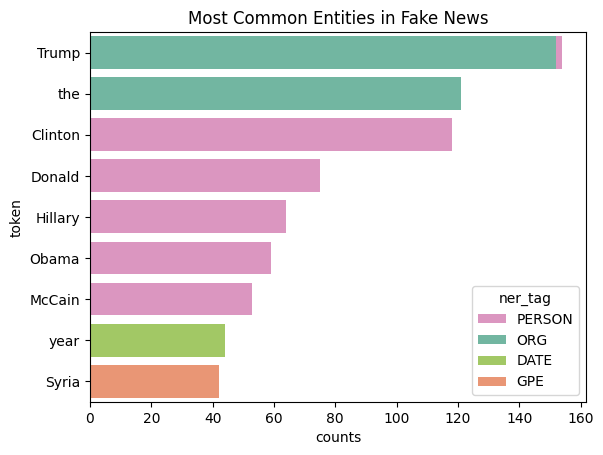

In [31]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

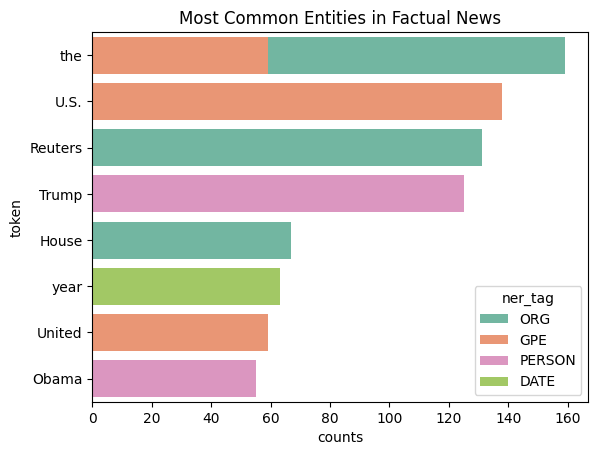

In [32]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Factual News')

In [44]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)


In [45]:
data['text_clean'] = data['text_clean'].str.lower()


In [46]:
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)


In [36]:
en_stopwords = stopwords.words('english')
print(en_stopwords) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [47]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)


In [48]:
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [49]:
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

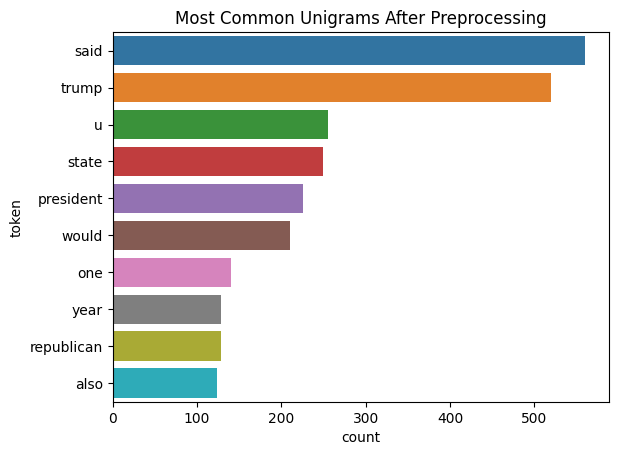

In [50]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count", 
            y = "token", 
            data=unigrams,
            orient = 'h',

            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [51]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()) 
print(bigrams[:10])

(donald, trump)        92
(united, state)        80
(white, house)         72
(president, donald)    42
(hillary, clinton)     31
(new, york)            31
(image, via)           29
(supreme, court)       29
(official, said)       26
(food, stamp)          24
Name: count, dtype: int64


In [52]:
vader_sentiment = SentimentIntensityAnalyzer()


In [53]:
data['vader_sentiment_score'] = data['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])


The `['compound']` key in this line of code extracts the compound sentiment score from the VADER sentiment analysis results, which is a normalized score ranging from -1 (most negative) to +1 (most positive). This score provides an overall sentiment polarity of the text, summarizing the sentiment in a single value.

In [54]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [55]:
bins = [-1, -0.5, 0.5, 1]
labels = ['Negative', 'Neutral', 'Positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins=bins, labels=labels)
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,Neutral
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,Negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,Positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,Neutral
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,Positive


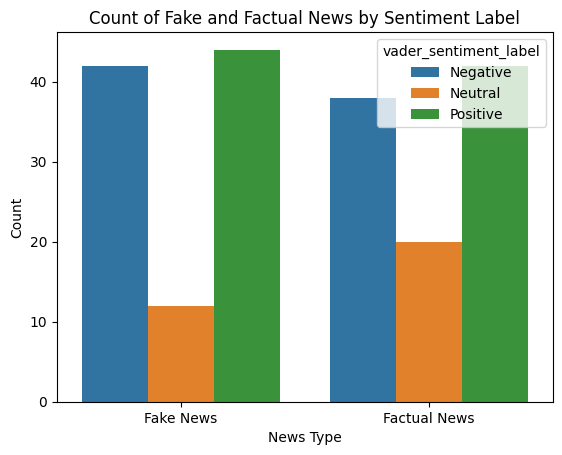

In [56]:

sns.countplot(x='fake_or_factual', hue='vader_sentiment_label', data=data)
plt.title('Count of Fake and Factual News by Sentiment Label')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='vader_sentiment_label'>

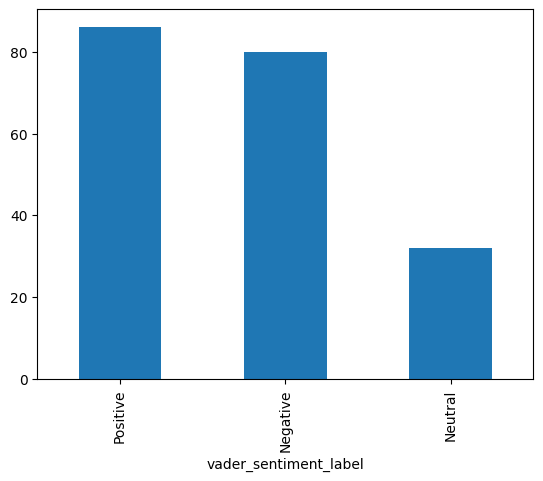

In [59]:
data['vader_sentiment_label'].value_counts().plot.bar()


In [60]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]


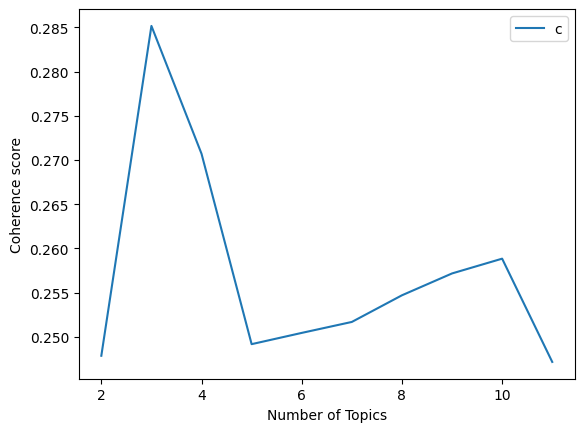

In [61]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [63]:
num_topics_fake = 3

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.009*"trump" + 0.004*"said" + 0.004*"republican" + 0.004*"clinton" + 0.004*"time" + 0.003*"president" + 0.003*"mccain" + 0.003*"one" + 0.003*"u" + 0.003*"official"'),
 (1,
  '0.010*"trump" + 0.005*"said" + 0.004*"would" + 0.004*"president" + 0.004*"state" + 0.003*"woman" + 0.003*"time" + 0.003*"u" + 0.003*"clinton" + 0.003*"one"'),
 (2,
  '0.012*"trump" + 0.005*"clinton" + 0.004*"said" + 0.004*"state" + 0.004*"president" + 0.004*"one" + 0.004*"would" + 0.003*"year" + 0.003*"people" + 0.003*"u"')]

In [70]:
pip install --upgrade gensim scipy


In [64]:

def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [76]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def get_coherence_scores(corpus, dictionary, texts, min_topics, max_topics):
    """
    Generate coherence scores to determine the optimal number of topics.
    Args:
        corpus: Corpus in Gensim format (e.g., TF-IDF transformed).
        dictionary: Gensim Dictionary object mapping terms to IDs.
        texts: List of tokenized texts for coherence evaluation.
        min_topics: Minimum number of topics to evaluate.
        max_topics: Maximum number of topics to evaluate.
    """
    coherence_values = []
    model_list = []

    for num_topics_i in range(min_topics, max_topics + 1):
        # Create LSI model for the given number of topics
        model = LsiModel(corpus=corpus, num_topics=num_topics_i, id2word=dictionary)
        model_list.append(model)

        # Compute coherence score
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    # Plot coherence values
    plt.figure(figsize=(10, 5))
    plt.plot(range(min_topics, max_topics + 1), coherence_values, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores vs Number of Topics")
    plt.legend(["Coherence Values"], loc='best')
    plt.grid()
    plt.show()

    return coherence_values, model_list

# Example usage
# Ensure you have the following variables defined:
# corpus_tfidf_fake: TF-IDF transformed corpus for fake news data
# dictionary_fake: Gensim Dictionary object for the corpus
# fake_news_text: List of tokenized texts

corpus_tfidf_fake = tfidf_corpus(doc_term_fake)


try:
    coherence_values, model_list = get_coherence_scores(
        corpus=corpus_tfidf_fake,
        dictionary=dictionary_fake,
        texts=fake_news_text,
        min_topics=2,
        max_topics=11
    )
except AttributeError as e:
    print(f"Error occurred: {e}")
    print("Try downgrading scipy to a compatible version, e.g., `scipy==1.9.3`.")


Error occurred: `scipy.sparse.sparsetools` has no attribute `csc_matvecs`; furthermore, `scipy.sparse.sparsetools` is deprecated and will be removed in SciPy 2.0.0.
Try downgrading scipy to a compatible version, e.g., `scipy==1.9.3`.


In [78]:

try:
    lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=3)
    lsa_fake.print_topics()
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: `scipy.sparse.sparsetools` has no attribute `csc_matvecs`; furthermore, `scipy.sparse.sparsetools` is deprecated and will be removed in SciPy 2.0.0.


In [79]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [80]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [82]:

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)


In [83]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)


In [84]:
y_pred_lr = lr.predict(X_test)


In [85]:
accuracy_score(y_pred_lr, y_test)


0.8833333333333333

In [86]:
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

Factual News       0.90      0.87      0.89        31
   Fake News       0.87      0.90      0.88        29

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [87]:
svm = SGDClassifier().fit(X_train, y_train)



In [88]:
y_pred_svm = svm.predict(X_test)


In [89]:
accuracy_score(y_pred_svm, y_test)


0.8833333333333333

In [90]:
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

Factual News       0.85      0.94      0.89        31
   Fake News       0.92      0.83      0.87        29

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60

